In [140]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib notebook

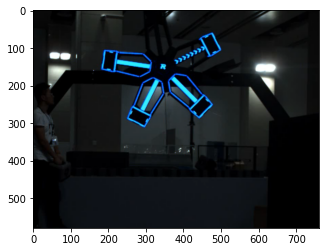

In [141]:
path = r'D:\photos\robomaster\8.png'
armor_color = 'blue'
img = cv2.imread(path, 1)
gray_img = cv2.imread(path, 0)
b, g, r = cv2.split(img)
plt.imshow(cv2.merge([r, g, b]))

colors=['blue','green','red']
for i in range(3):
    hist,x=np.histogram(img[:,:,i].ravel(),bins=256,range=(0,256))
    plt.plot(0.5*(x[:-1]+x[1:]),hist,label=colors[i],color=colors[i])
plt.show()

histgray,xgray=np.histogram(gray_img.ravel(),bins=256,range=(0,256))
plt.figure()
plt.plot(0.5*(xgray[:-1]+xgray[1:]),histgray)
plt.show()

def abstract_channels(a, b):
    arr = np.zeros_like(a)
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            pixel = a[i][j] - b[i][j]
            if pixel < 0:
                arr[i][j] = 0
            elif pixel < 50:
                arr[i][j] = 0
            elif pixel == 255:
                arr[i][j] = 0
            else:
                arr[i][j] = pixel
    return arr

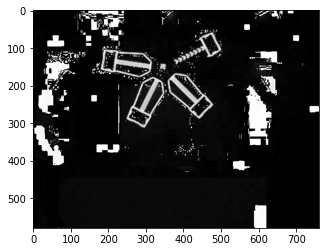

In [142]:
red_img = r - b if armor_color == 'red' else b - r
plt.imshow(red_img, cmap='gray')

red_img = abstract_channels(r, b) if armor_color == 'red' else \
abstract_channels(b, r)
plt.imshow(red_img, cmap='gray')

histgray,xgray=np.histogram(red_img.ravel(),bins=256,range=(0,256))
plt.figure()
plt.plot(0.5*(xgray[:-1]+xgray[1:]),histgray)
plt.show()

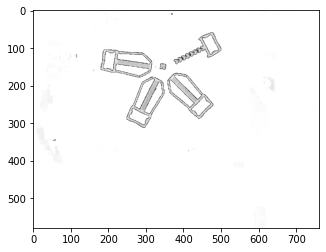

In [147]:
width, height = red_img.shape
for x in range(width):
    for y in range(height):
        if red_img[x, y] < 50:
            red_img[x, y] = 255
plt.imshow(red_img, cmap='gray')

kernel = np.ones((3,3),np.uint8)
erosion = cv2.erode(red_img, kernel,iterations=2)
plt.imshow(erosion,'gray')

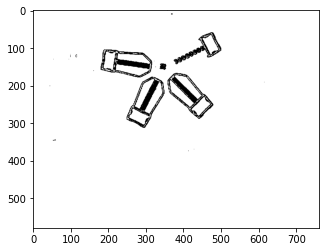

In [160]:
bin_img2 = cv2.threshold(red_img, 230, 255, cv2.THRESH_BINARY)[1]
plt.imshow(bin_img2, cmap='gray')

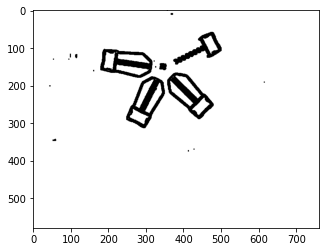

In [166]:
kernel = np.ones((3,3),np.uint8)
erosion = cv2.erode(bin_img2,kernel,iterations=1)
plt.imshow(erosion,'gray')

width, height = bin_img2.shape
for x in range(width):
    for y in range(height):
        if bin_img2[x, y] >180:
            bin_img2[x, y] = 0
        else:
            bin_img2[x, y] = 255
plt.imshow(bin_img2, cmap='gray')

kernel = np.ones((4,4),np.uint8)
dilation = cv2.dilate(bin_img2,kernel,iterations=2)
erosion = cv2.erode(dilation, kernel, iterations=2)
plt.imshow(erosion,'gray')

579 761


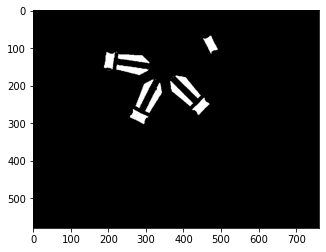

In [168]:
h, w = erosion.shape
print(h, w)
mask = np.zeros([h+2, w+2], np.uint8)
im = erosion.copy()
cv2.floodFill(im, mask, (30, 30), 0, 10, 10,
              cv2.FLOODFILL_FIXED_RANGE)
plt.imshow(im,'gray')

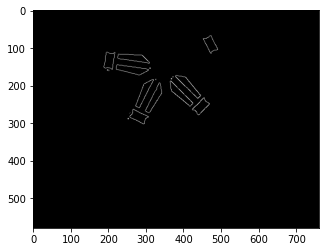

In [169]:
edge = cv2.Canny(im, 0, 255) #后两参数无影响
plt.imshow(edge,'gray')

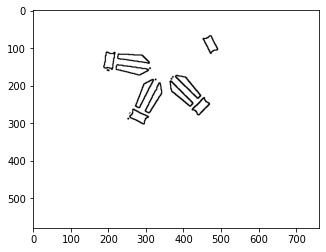

In [170]:
contours,hierarchy = cv2.findContours(edge, 
                            cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
white_canvas = np.ones([edge.shape[0], edge.shape[1], 3], 
                       dtype=np.uint8)*255
cv2.drawContours(white_canvas, contours, -1, 0, 2)
plt.imshow(white_canvas)

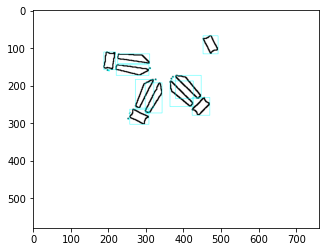

In [171]:
for i in range(len(contours)):
    x, y, w, h = cv2.boundingRect(contours[i]) 
    cv2.rectangle(white_canvas, (x, y), (x + w, y + h), (0, 255, 255), 1)
plt.imshow(white_canvas)

vertex_list = list(filter(lambda x: x.size == 8, vertex_list))

In [176]:
blade_width = []
armor_list, armor_center = [], []
blade_list, blade_center = [], []
for contour in contours:
    rectangle = cv2.minAreaRect(contour)
    width, height = sorted(rectangle[1])
    if width < 5 or height < 15:
        continue
    if height / width > 2:
        blade_width.append(width)
        blade_list.append(cv2.boxPoints(rectangle))
        blade_center.append(rectangle[0])
    else:
        armor_list.append(cv2.boxPoints(rectangle))
        armor_center.append(rectangle[0])

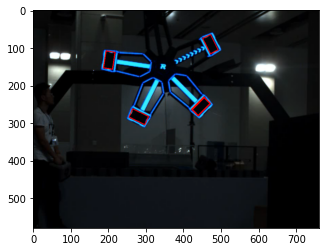

In [179]:
for armor in armor_list:
    for j in range(4):
        cv2.line(img, tuple(armor[j]), tuple(
            armor[(j + 1) % 4]), (0, 0, 255), 2)
plt.imshow(img[:,:,[2,1,0]])

In [180]:
filtered_armor_center = []
while armor_center:
    center = armor_center.pop()
    for point in armor_center:
        if abs(center[0] - point[0]) < 5 and abs(center[1] - point[1]) < 5:
            armor_center.remove(point)
    filtered_armor_center.append(center)

filtered_blade_center = []
while blade_center:
    center = blade_center.pop()
    for point in blade_center:
        if abs(center[0] - point[0]) < 10 and abs(center[1] - point[1]) < 10:
            blade_center.remove(point)
    filtered_blade_center.append(center)

width = int(sum(blade_width) / len(blade_width)) if blade_width else None
while filtered_blade_center:
    center = filtered_blade_center.pop()
    for point in filtered_blade_center:
        if abs(center[0] - point[0]) < width * \
                2 and abs(center[1] - point[1]) < width * 2:
            blade_center.append(
                ((center[0] + point[0]) / 2,
                 (center[1] + point[1]) / 2))
            filtered_blade_center.remove(point)
            break
            
print('blade_center', blade_center)
print('filtered_armor_center', filtered_armor_center)
filtered_armor_center = [tuple(map(int, num_tuple))
                         for num_tuple in filtered_armor_center]  # 浮点数转整

blade_center_num = len(blade_center)
def distance(point1, point2):
    return ((point1[0] - point2[0]) ** 2 +
            (point1[1] - point2[1]) ** 2) ** (1 / 2)
if not blade_center_num:  # 无扇叶时，直接将唯一的装甲板识别为待打击对象
    cv2.circle(
        img,
        filtered_armor_center[0],
        4,
        (255, 255, 0),
        thickness=-1)  # thickness为负表示填充圆形
else:  # 有扇叶时，已知相邻两扇叶的中心，计算与每个装甲板中心的距离，最近的即为配对的装甲板，筛选剩的即为待击打对象
    for blade_point in blade_center:
        distance_list = []
        for armor_point in filtered_armor_center:
            distance_list.append(distance(blade_point, armor_point))
        # 找到离扇叶中心最近的装甲板并将其删除
        index = distance_list.index(min(distance_list))
        del filtered_armor_center[index]
    # 画出最后剩下的一个装甲板的位置
    if filtered_armor_center:
        cv2.circle(
            img,
            filtered_armor_center[0],
            4,
            (255, 255, 0),
            thickness=-1)  # thickness为负表示填充圆形

blade_center [(308.9770812988281, 226.2622299194336), (402.0004425048828, 211.2945556640625), (265.5602264404297, 142.60335540771484)]
filtered_armor_center [(472.300048828125, 90.60001373291016), (202.66488647460938, 132.78919982910156), (447.00006103515625, 256.0000305175781), (281.50238037109375, 283.23193359375)]


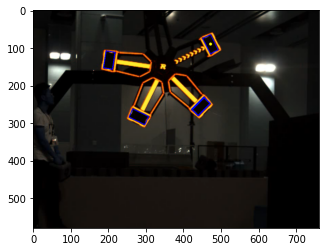

In [181]:
plt.imshow(img)